## MARBL diagnostics, compare timeseries of global metrics between 2 cases


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cftime
import utils
import pandas as pd
import pop_tools
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from xgcm import Grid
xr.set_options(keep_attrs=True);

### Define cases

In [2]:
case = 'g.e30_b07.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.007'
case2 = 'g.e30_b07.GW1850MARBL_JRA.TL319_t232_wgx3_hycom1_N75.011'
user = 'kristenk'

## Define the year range to examine and get the CESM history files

In [3]:
start_yr = 1
num_years = 4
endyr = start_yr + num_years 

#### first get the 3-D variables

In [4]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !


In [5]:
cesm_mon_ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

#### Now grab the 2-D variables

In [6]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case}/ocn/hist/{case}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !


In [7]:
cesm_mon_ds2 = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

In [8]:
#cesm_mon_ds2

### Keep only the variables we need (use this list for both 2-D and 3-D datasets)

In [9]:
variables2d = ['IRON_FLUX','DUST_FLUX','ATM_FINE_DUST_FLUX_CPL','ATM_COARSE_DUST_FLUX_CPL','ATM_BLACK_CARBON_FLUX_CPL'] 

variables3d = ['Fe_scavenge','Fe'] 


coords = {'x':'yh','y':'xh'}

### get the second case

In [10]:
start_yr = 1
num_years = 4
endyr = start_yr + num_years 

In [11]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case2}/ocn/hist/{case2}.mom6.h.bgc.z.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !


In [12]:
cesm_mon_dsB = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

In [13]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/derecho/scratch/{user}/archive/{case2}/ocn/hist/{case2}.mom6.h.bgc.native.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 1 !
doing simulation year 2 !
doing simulation year 3 !
doing simulation year 4 !


In [14]:
cesm_mon_ds2B = xr.open_mfdataset(files,decode_times=True,decode_coords=False, concat_dim='time')

### Drop unnecessary variables

In [15]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables3d + list(coords.values())
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keepthese])
cesm_mon_dsB = cesm_mon_dsB.drop([v for v in cesm_mon_dsB.variables if v not in keepthese])

In [16]:
keepthese=['z_l','z_i','time_bounds','time','average_T1', 'average_T2','average_DT'] + variables2d + list(coords.values())
cesm_mon_ds2 = cesm_mon_ds2.drop([v for v in cesm_mon_ds2.variables if v not in keepthese])
cesm_mon_ds2B = cesm_mon_ds2B.drop([v for v in cesm_mon_ds2B.variables if v not in keepthese])

## Get the grid data for MOM6

In [17]:
ds_grid = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e23b16.TL319_t232.GIAFMARBL.001.mom6.h.static.nc')
ds_grid2 = xr.open_dataset(f'/glade/work/kristenk/cesm_work/mom6_static_files/g.e30_b06.GJRAv4.TL319_t232_wgx3_hycom1_N75.2025.081.mom6.h.ocean_geometry.nc')

In [18]:
lons = ds_grid.geolon
lats = ds_grid.geolat
area = ds_grid.areacello #m2
depths = cesm_mon_ds.z_l

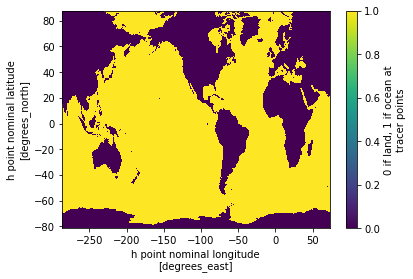

In [19]:
ds_grid.wet.plot()

#### Make my own dz variable

In [20]:
dz = np.zeros([34])

i = 0

for int in cesm_mon_ds.z_i.values[1:35]:
    
    level_up = cesm_mon_ds.z_i.values[i]
    #print(level_up,int)
    dz[i] = int - level_up

    i = i + 1

dz = xr.DataArray(dz,dims=('z_l'))

### spin up a bit of dask

In [21]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [22]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Client Scheduler: tcp://128.117.208.175:35351 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/45615/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Make the annual mean

In [23]:
cesm_ann_ds = cesm_mon_ds.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [24]:
cesm_ann_ds2 = cesm_mon_ds2.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [25]:
cesm_ann_dsB = cesm_mon_dsB.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [26]:
cesm_ann_ds2B = cesm_mon_ds2B.resample({'time':'A'}).mean(dim='time', keep_attrs=True).compute()

In [27]:
cesm_ann_ds2

<xarray.Dataset>
Dimensions:                    (time: 4, xh: 540, yh: 480)
Coordinates:
  * time                       (time) object 0001-12-31 00:00:00 ... 0004-12-...
  * xh                         (xh) float64 -286.7 -286.0 -285.3 ... 72.0 72.67
  * yh                         (yh) float64 -81.56 -81.46 -81.36 ... 87.71 87.74
Data variables:
    ATM_FINE_DUST_FLUX_CPL     (time, yh, xh) float32 nan nan nan ... nan nan
    ATM_COARSE_DUST_FLUX_CPL   (time, yh, xh) float32 nan nan nan ... nan nan
    ATM_BLACK_CARBON_FLUX_CPL  (time, yh, xh) float32 nan nan nan ... nan nan
    DUST_FLUX                  (time, yh, xh) float32 nan nan nan ... nan nan
    IRON_FLUX                  (time, yh, xh) float32 nan nan nan ... nan nan
    average_DT                 (time) timedelta64[ns] 30 days 10:00:00 ... 30...
Attributes:
    NumFilesInSet:     1
    title:             MOM6 diagnostic fields table for CESM case: g.e30_b07....
    associated_files:  areacello: g.e30_b07.GW1850MARBL_JRA.TL319_t232_wgx3_h...
    grid_type:         regular
    grid_tile:         N/A

### Make difference maps



In [28]:
ds_diff2 = cesm_ann_ds2B - cesm_ann_ds2
ds_diff = cesm_ann_dsB - cesm_ann_ds

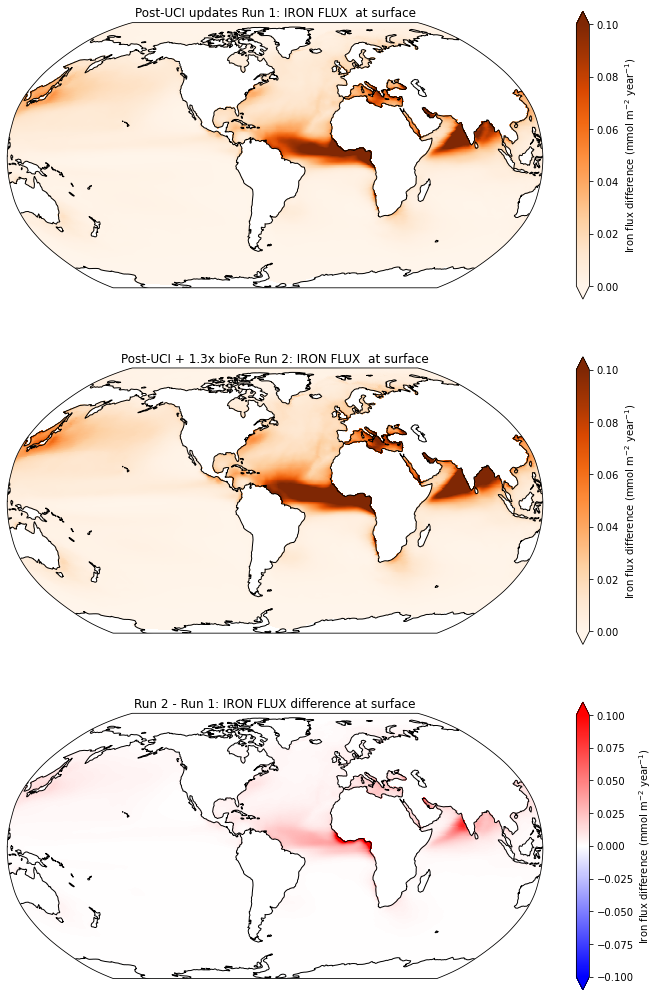

In [29]:
fig = plt.figure(figsize=(12,18))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI updates Run 1: IRON FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2.IRON_FLUX.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.1,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Iron flux difference (mmol m$^{-2}$ year$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI + 1.3x bioFe Run 2: IRON FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2B.IRON_FLUX.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.1,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Iron flux difference (mmol m$^{-2}$ year$^{-1}$)')




ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: IRON FLUX difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_diff2.IRON_FLUX.mean(dim='time')*86400*365, cmap='bwr',
                 vmin=-0.1,vmax=0.1,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Iron flux difference (mmol m$^{-2}$ year$^{-1}$)')

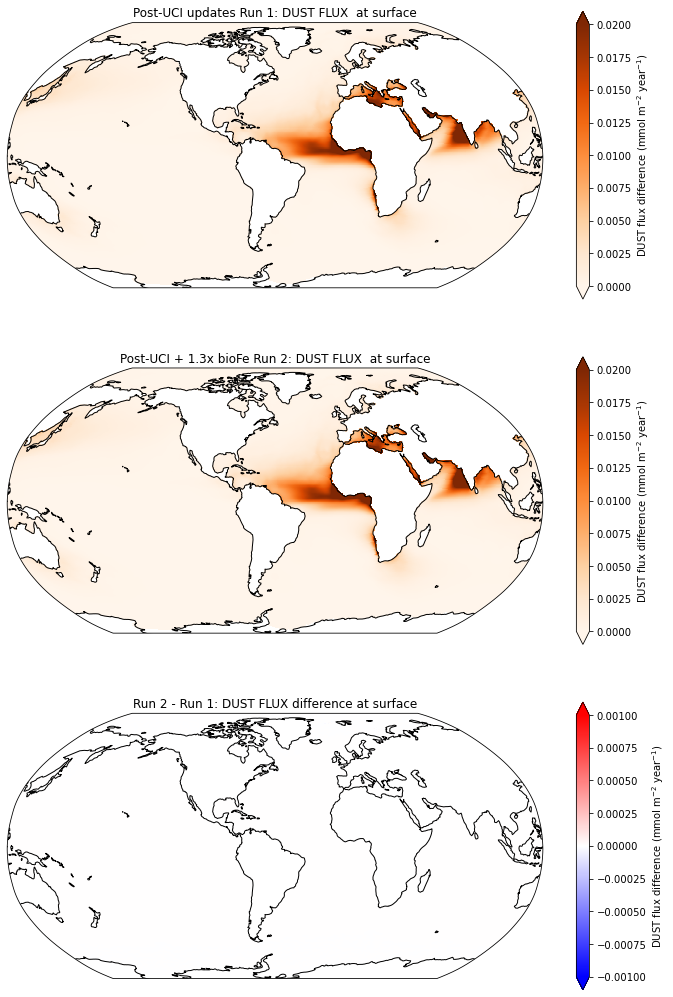

In [30]:
fig = plt.figure(figsize=(12,18))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI updates Run 1: DUST FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2.DUST_FLUX.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.02,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='DUST flux difference (mmol m$^{-2}$ year$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI + 1.3x bioFe Run 2: DUST FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2B.DUST_FLUX.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.02,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='DUST flux difference (mmol m$^{-2}$ year$^{-1}$)')




ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: DUST FLUX difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_diff2.DUST_FLUX.mean(dim='time')*86400*365, cmap='bwr',
                 vmin=-0.001,vmax=0.001,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='DUST flux difference (mmol m$^{-2}$ year$^{-1}$)')

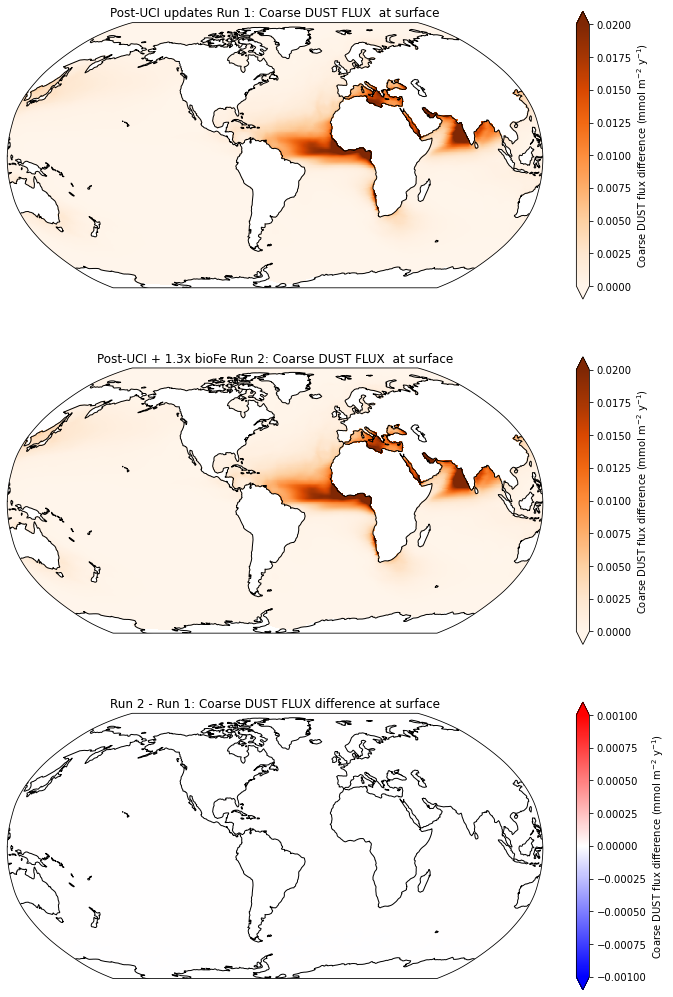

In [31]:
fig = plt.figure(figsize=(12,18))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI updates Run 1: Coarse DUST FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2.ATM_COARSE_DUST_FLUX_CPL.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.02,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Coarse DUST flux difference (mmol m$^{-2}$ y$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI + 1.3x bioFe Run 2: Coarse DUST FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2B.ATM_COARSE_DUST_FLUX_CPL.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.02,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Coarse DUST flux difference (mmol m$^{-2}$ y$^{-1}$)')




ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: Coarse DUST FLUX difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_diff2.ATM_COARSE_DUST_FLUX_CPL.mean(dim='time')*86400*365, cmap='bwr',
                 vmin=-0.001,vmax=0.001,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Coarse DUST flux difference (mmol m$^{-2}$ y$^{-1}$)')

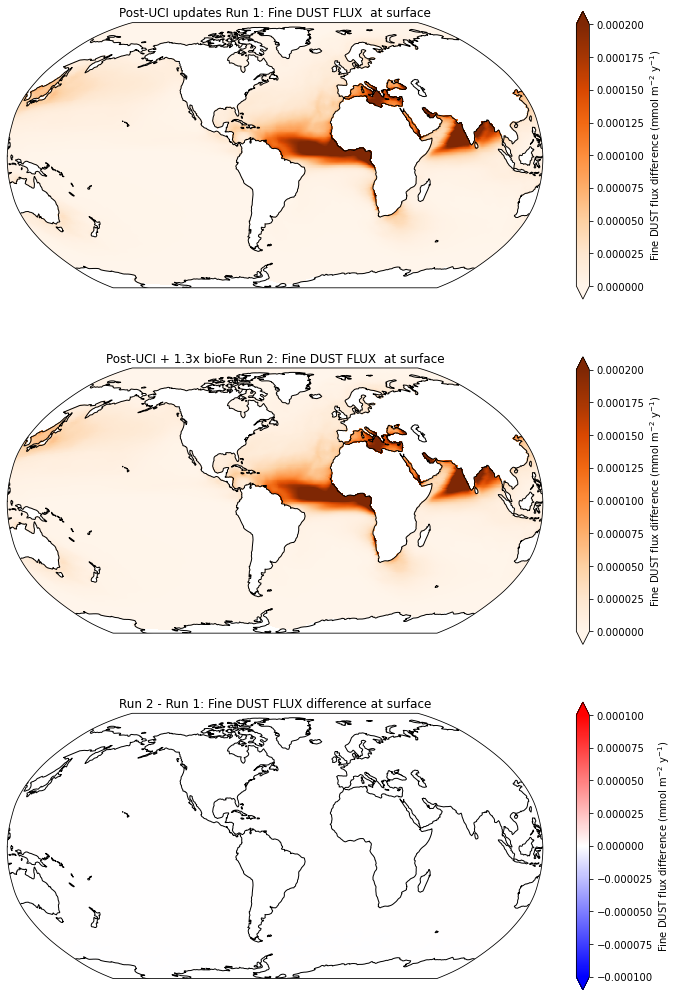

In [32]:
fig = plt.figure(figsize=(12,18))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI updates Run 1: Fine DUST FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2.ATM_FINE_DUST_FLUX_CPL.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.0002,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Fine DUST flux difference (mmol m$^{-2}$ y$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI + 1.3x bioFe Run 2: Fine DUST FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2B.ATM_FINE_DUST_FLUX_CPL.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.0002,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Fine DUST flux difference (mmol m$^{-2}$ y$^{-1}$)')




ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: Fine DUST FLUX difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_diff2.ATM_FINE_DUST_FLUX_CPL.mean(dim='time')*86400*365, cmap='bwr',
                 vmin=-0.0001,vmax=0.0001,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Fine DUST flux difference (mmol m$^{-2}$ y$^{-1}$)')

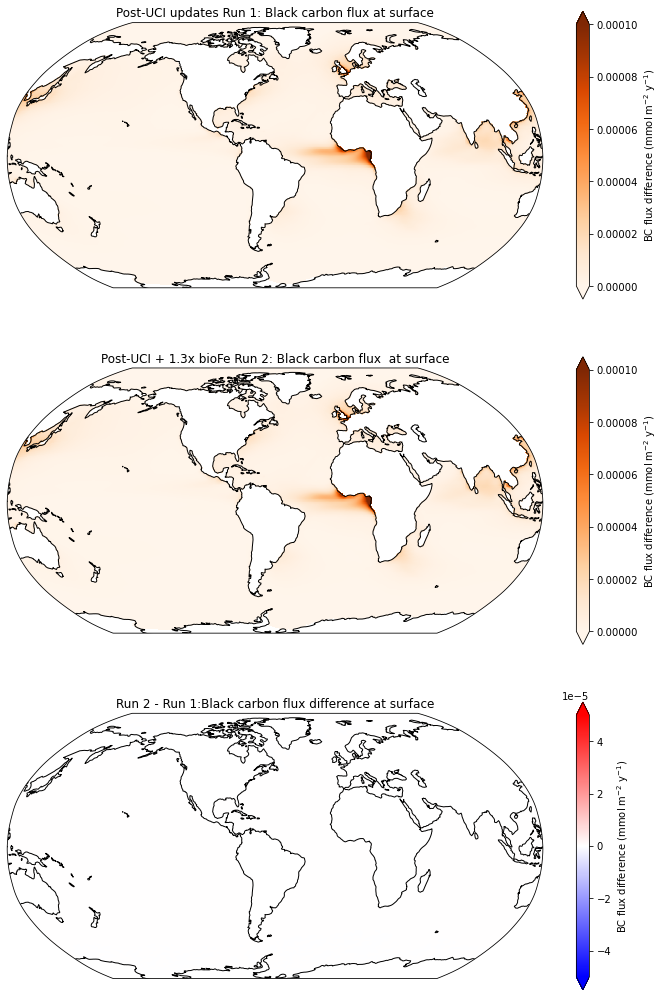

In [33]:
fig = plt.figure(figsize=(12,18))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI updates Run 1: Black carbon flux at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2.ATM_BLACK_CARBON_FLUX_CPL.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.0001,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='BC flux difference (mmol m$^{-2}$ y$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI + 1.3x bioFe Run 2: Black carbon flux  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds2B.ATM_BLACK_CARBON_FLUX_CPL.mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.0001,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='BC flux difference (mmol m$^{-2}$ y$^{-1}$)')




ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1:Black carbon flux difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_diff2.ATM_BLACK_CARBON_FLUX_CPL.mean(dim='time')*86400*365, cmap='bwr',
                 vmin=-0.00005,vmax=0.00005,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='BC flux difference (mmol m$^{-2}$ y$^{-1}$)')

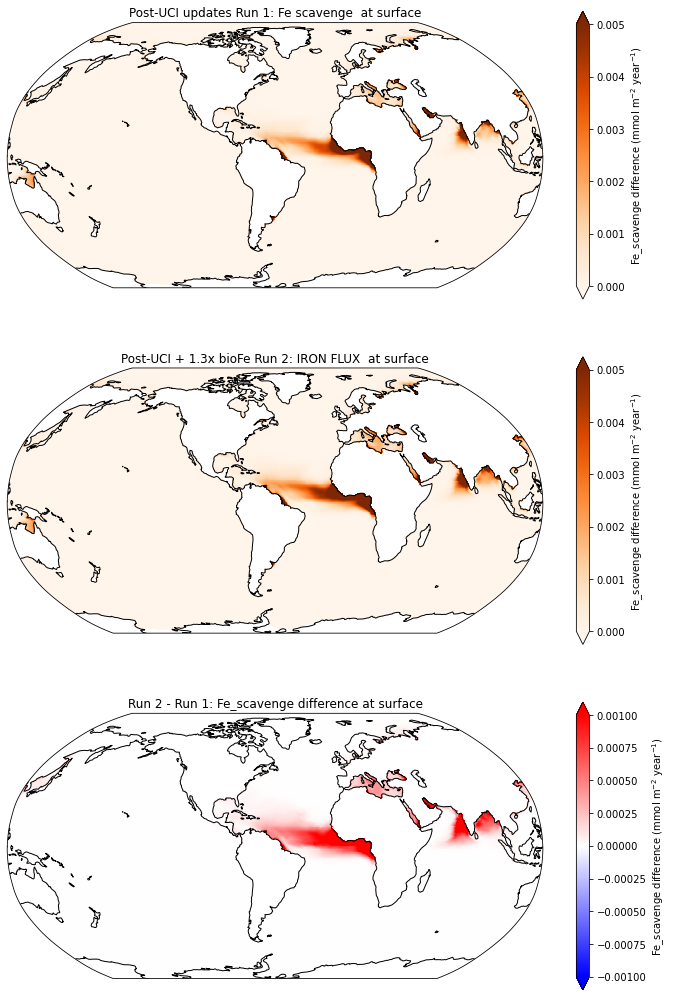

In [34]:
fig = plt.figure(figsize=(12,18))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI updates Run 1: Fe scavenge  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_ds.Fe_scavenge.isel(z_l=0).mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.005,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Fe_scavenge difference (mmol m$^{-2}$ year$^{-1}$)')

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Post-UCI + 1.3x bioFe Run 2: IRON FLUX  at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, cesm_ann_dsB.Fe_scavenge.isel(z_l=0).mean(dim='time')*86400*365, cmap='Oranges',
                 vmin=0,vmax=0.005,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Fe_scavenge difference (mmol m$^{-2}$ year$^{-1}$)')




ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Run 2 - Run 1: Fe_scavenge difference at surface', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_diff.Fe_scavenge.isel(z_l=0).mean(dim='time')*86400*365, cmap='bwr',
                 vmin=-0.001,vmax=0.001,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=1)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Fe_scavenge difference (mmol m$^{-2}$ year$^{-1}$)')

In [35]:
ds_glb = xr.Dataset()
convert = 1e-3 * 365. * 86400.

variables = ['IRON_FLUX']


for v in variables:
    ds_glb[v] = ((cesm_ann_ds2[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glb[v].attrs = cesm_ann_ds2[v].attrs

    ds_glb[v] = ds_glb[v] * convert        
    #ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glb = ds_glb.compute()

In [36]:
ds_glb.IRON_FLUX

<xarray.DataArray 'IRON_FLUX' (time: 4)>
array([4.0198241e+09, 4.0358999e+09, 4.0306004e+09, 4.0294561e+09],
      dtype=float32)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0004-12-31 00:00:00
Attributes:
    units:          mmol/m^2/s
    long_name:      Atmospheric Iron Flux
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

In [37]:
ds_glbB = xr.Dataset()
convert = 1e-3 * 365. * 86400.

variables = ['IRON_FLUX']


for v in variables:
    ds_glbB[v] = ((cesm_ann_ds2B[v] * area).sum(dim=('xh', 'yh'))).compute() #mmol/m
    ds_glbB[v].attrs = cesm_ann_ds2B[v].attrs

    ds_glbB[v] = ds_glbB[v] * convert        
    #ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds_glbB = ds_glbB.compute()

In [38]:
ds_glbB.IRON_FLUX

<xarray.DataArray 'IRON_FLUX' (time: 4)>
array([5.225751e+09, 5.246703e+09, 5.239779e+09, 5.238282e+09],
      dtype=float32)
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 0004-12-31 00:00:00
Attributes:
    units:          mmol/m^2/s
    long_name:      Atmospheric Iron Flux
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT

### Make some timeseries plots

In [39]:
years = np.arange(1,len(ds_glb.time)+1,1)
yearsB = np.arange(1,len(ds_glbB.time)+1,1)

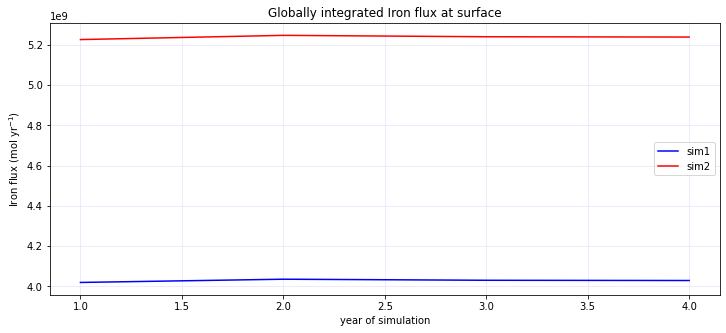

In [40]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1)
ax.set_title('Globally integrated Iron flux at surface')
ax.plot(years,ds_glb['IRON_FLUX'],color='blue',label='sim1')
ax.plot(yearsB,ds_glbB['IRON_FLUX'],color='red',label='sim2')
ax.xaxis.grid(True, which='major',color='lavender')
ax.yaxis.grid(False, which='major',color='lavender');
ax.legend()
ax.set(ylabel='Iron flux (mol yr$^{-1}$)',xlabel='year of simulation');